This Notebook will find optimal wieghts using MPT, then will back test those wieghts 1 year fowrad from data collections

In [1]:
import time
import os 

start_time = time.time() # measure run time

WORKSPACE_DIR = os.getenv('WORKSPACE_DIR')
if not os.getcwd().endswith('portfolio_py'):
    os.chdir(f'{WORKSPACE_DIR}/portfolio_py')
print(f'Current Working Directory: {os.getcwd()}')


Current Working Directory: /Users/blakeuribe/Desktop/portfolio_py


Get Back Test Dates

In [2]:
from datetime import datetime
from dateutil.relativedelta import relativedelta
from utils.config import PROGRAM_START_DATE, PROGRAM_END_DATE, mpt_stocks_for_profit, mpt_stocks_for_sharpe
from utils.finance_utils import backtest_portfolio, MPTOptimizer, plot_cum_ret

date_obj = datetime.strptime(PROGRAM_END_DATE, "%Y-%m-%d")  # Convert string to datetime objectb
backtest_end = date_obj + relativedelta(years=1)

backtest_start = PROGRAM_END_DATE


Updated on 03/05/2025 5:44

---------------------------------
finance_utils.py successfully loaded, updated last Feb. 24 2025 5:26
---------------------------------




Conduct MPT

--MPT on High Profit--
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  8 of 8 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


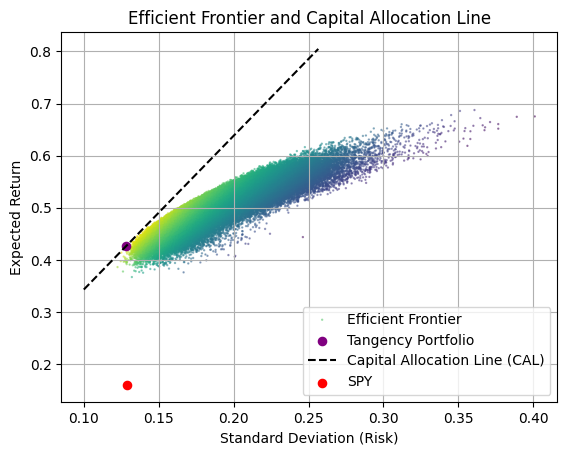

[**********************75%***********            ]  6 of 8 completed

-- Optimal Portfolio (CAL) --
Max Sharpe Ratio: 2.95
Corresponding Return: 0.43
Corresponding Standard Deviation: 0.13
Optimal Weights: {'BABA': np.float64(0.11846188365314948), 'GDDY': np.float64(0.15945098323376275), 'CQP': np.float64(0.12727369313494058), 'DUK': np.float64(0.3095084309775628), 'SYF': np.float64(0.12891391728415041), 'BKNG': np.float64(0.11273002728189192), 'VST': np.float64(0.014539390218558398), 'GRMN': np.float64(0.029121674215983613)}

--MPT on High Sharpe--


[*********************100%***********************]  8 of 8 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


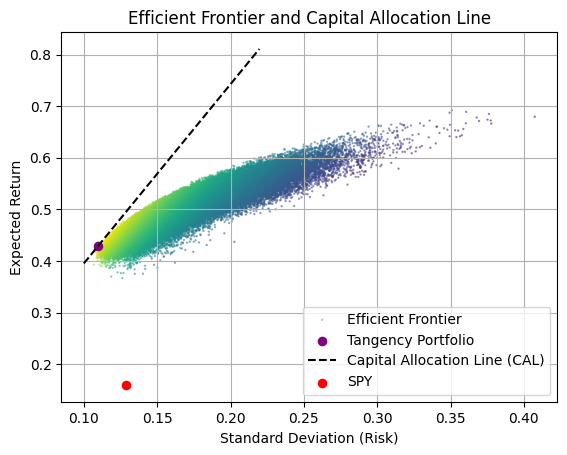

-- Optimal Portfolio (CAL) --
Max Sharpe Ratio: 3.47
Corresponding Return: 0.43
Corresponding Standard Deviation: 0.11
Optimal Weights: {'BABA': np.float64(0.08999968688709639), 'GDDY': np.float64(0.1089725517526957), 'CQP': np.float64(0.0328913767737596), 'DUK': np.float64(0.2664736205108929), 'K': np.float64(0.1368344889296891), 'BKNG': np.float64(0.08634434504703821), 'VST': np.float64(0.2586872797811176), 'GRMN': np.float64(0.019796650317710395)}


In [3]:
print('--MPT on High Profit--')
optimizer_for_high_profit = MPTOptimizer(mpt_stocks_for_profit, start_date=PROGRAM_START_DATE, end_date=PROGRAM_END_DATE)
optimizer_for_high_profit.simulate_portfolios()
optimizer_for_high_profit.plot_efficient_frontier()
tangecy_portfolio_for_profit_stocks = optimizer_for_high_profit.find_tangency_portfolio()

print('\n--MPT on High Sharpe--')
optimizer_for_high_sharpe = MPTOptimizer(mpt_stocks_for_sharpe, start_date=PROGRAM_START_DATE, end_date=PROGRAM_END_DATE)
optimizer_for_high_sharpe.simulate_portfolios()
optimizer_for_high_sharpe.plot_efficient_frontier()
tangecy_portfolio_for_sharpe_stocks = optimizer_for_high_sharpe.find_tangency_portfolio()


In [4]:
import datetime

program_start_date_obj = datetime.datetime.strptime(backtest_start, '%Y-%m-%d')

# Check if the year is less than 2021
if program_start_date_obj.year < 2021:
    print("Will need to use IRX")
    risk_rate_ticker = '^IRX'
else:
    print("we can use sgov")
    risk_rate_ticker = 'SGOV'

we can use sgov


In [5]:
from utils.finance_utils import find_lending_or_borrowing_portfolio


# Benchmark Metrics
spy_return = optimizer_for_high_profit.spy_return.iloc[0]
spy_std = optimizer_for_high_profit.spy_std.iloc[0]
risk_free_rate = optimizer_for_high_profit.risk_free_rate.iloc[0] # Optimizer uses mean rate

# Info for high profit stocks
stock_weight_dict_profit = tangecy_portfolio_for_profit_stocks[0]
tangecy_portfolio_metrics_dict_profit = tangecy_portfolio_for_profit_stocks[1]

# Info for high profit stocks
stock_weight_dict_sharpe = tangecy_portfolio_for_sharpe_stocks[0]
tangecy_portfolio_metrics_dict_sharpe = tangecy_portfolio_for_sharpe_stocks[1]


# Find lending or borrowing for 
portfolio_allocation_high_profit = find_lending_or_borrowing_portfolio(
    tangecy_portfolio_metrics_dict_profit['Corresponding Return'],
    tangecy_portfolio_metrics_dict_profit['Corresponding Standard Deviation'],
    risk_free_rate,
    spy_std,
    list(stock_weight_dict_profit.keys()),
    list(stock_weight_dict_profit.values()),
    add_margin=True,
    risk_free_proxy=risk_rate_ticker
    )

portfolio_allocation_high_sharpe = find_lending_or_borrowing_portfolio(
    tangecy_portfolio_metrics_dict_sharpe['Corresponding Return'],
    tangecy_portfolio_metrics_dict_sharpe['Corresponding Standard Deviation'],
    risk_free_rate,
    spy_std,
    list(stock_weight_dict_sharpe.keys()),
    list(stock_weight_dict_sharpe.values()),
    add_margin=True,
    risk_free_proxy=risk_rate_ticker
    )



Begin Back Testing

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

----Begining Back Test----
Back Test starts on: 2025-03-01
Back Test ends on: 2026-03-01 00:00:00



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%*******

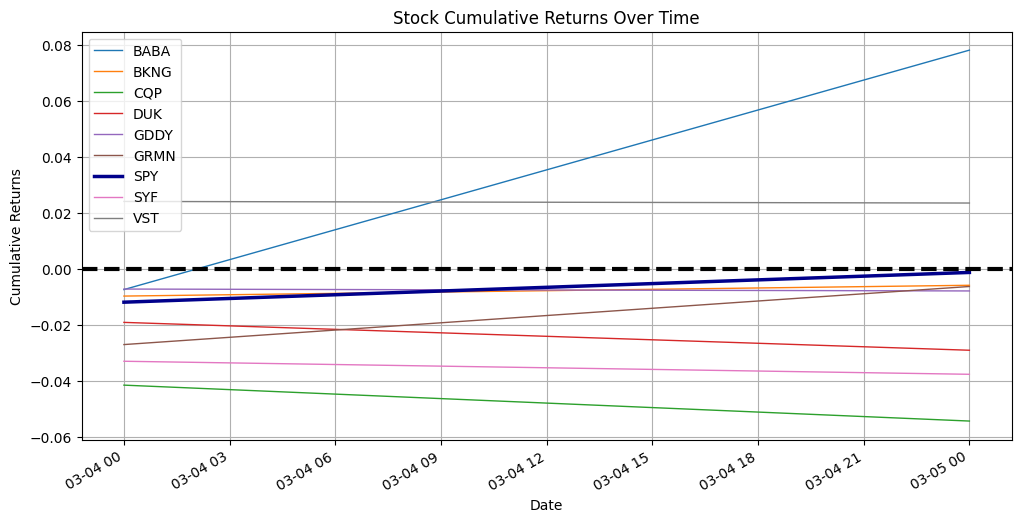

[*********************100%***********************]  9 of 9 completed


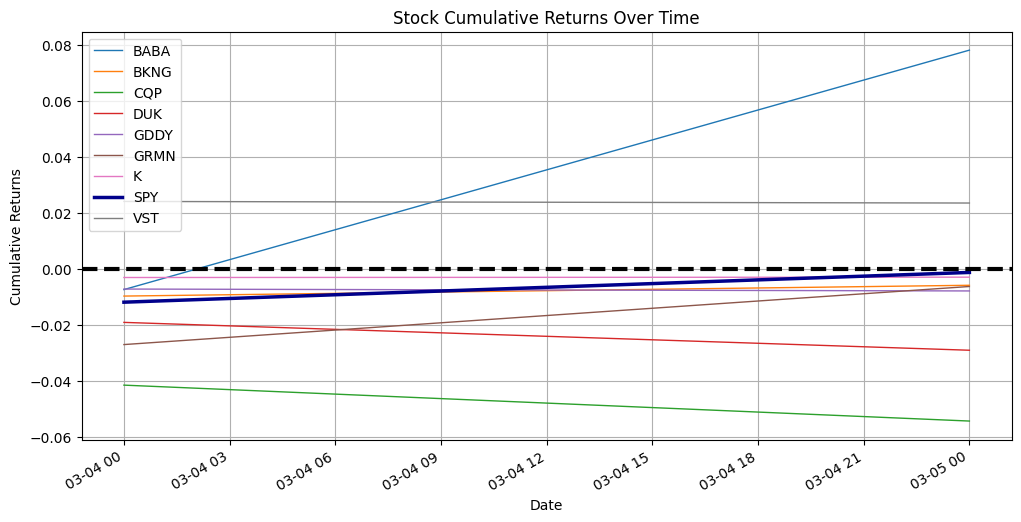

In [6]:

print('----Begining Back Test----')
print(f'Back Test starts on: {backtest_start}')
print(f'Back Test ends on: {backtest_end}')

paper_value = 100_000
backtest_spy_return = backtest_portfolio(['spy'], 1, [1], start_date=backtest_start, end_date=backtest_end)-1

# Run the backtest
backtest_on_high_profit = backtest_portfolio(portfolio_allocation_high_profit['Stocks'], paper_value, portfolio_allocation_high_profit['Stock Weights'], start_date=backtest_start, end_date=backtest_end)
backtest_on_high_sharpe = backtest_portfolio(portfolio_allocation_high_sharpe['Stocks'], paper_value, portfolio_allocation_high_sharpe['Stock Weights'], start_date=backtest_start, end_date=backtest_end)
plot_cum_ret(mpt_stocks_for_profit + ['SPY'],  start_date=backtest_start, end_date=backtest_end)
plot_cum_ret(mpt_stocks_for_sharpe + ['SPY'], start_date=backtest_start, end_date=backtest_end)

Record Results

In [7]:
import pandas as pd
import os

# Define file path
file_path = f"{WORKSPACE_DIR}/portfolio_py/data/clean/backtest_results.csv"

# Check if file exists
if os.path.exists(file_path):
    # Load existing data
    backtest_df = pd.read_csv(file_path)
else:
    # Create a new DataFrame if the file doesn't exist
    backtest_df = pd.DataFrame(columns=[
        "Data_Collection_Start", "Data_Collection_End",
        "Backtest_Start", "Backtest_End",
        "Stock_Selection_Method", 'Stocks', 'Sharpe', "Starting_Value", "Ending_Value"
    ])

# New entries to append
new_entries = [
    {
        "Data_Collection_Start": PROGRAM_START_DATE,
        "Data_Collection_End": PROGRAM_END_DATE,
        "Backtest_Start": backtest_start,
        "Backtest_End": backtest_end,
        "Stock_Selection_Method": "High Profit Stocks",
        "Stocks": (",".join(portfolio_allocation_high_profit['Stocks'])),
        'Sharpe': tangecy_portfolio_for_profit_stocks[1]['Max Sharpe'],
        "Starting_Value": paper_value,
        "Ending_Value": backtest_on_high_profit,
        'SPY Retrun': backtest_spy_return
    },
    {
        "Data_Collection_Start": PROGRAM_START_DATE,
        "Data_Collection_End": PROGRAM_END_DATE,
        "Backtest_Start": backtest_start,
        "Backtest_End": backtest_end,
        "Stock_Selection_Method": "High Sharpe Ratio Stocks",
        "Stocks": (",".join(portfolio_allocation_high_sharpe['Stocks'])),
        'Sharpe': tangecy_portfolio_for_sharpe_stocks[1]['Max Sharpe'],
        "Starting_Value": paper_value,
        "Ending_Value": backtest_on_high_sharpe,
        'SPY Retrun': backtest_spy_return

    }
]

# Convert new entries to a DataFrame
new_entries_df = pd.DataFrame(new_entries)

# Drop duplicates before writing
backtest_df = pd.concat([backtest_df, new_entries_df], ignore_index=True).drop_duplicates()

# **Append** to the CSV without overwriting
backtest_df.to_csv(file_path, index=False, mode="w")  

print("New rows added successfully (without overwriting)!") 


New rows added successfully (without overwriting)!


In [8]:
backtest_df

,Data_Collection_Start,Data_Collection_End,Backtest_Start,Backtest_End,Stock_Selection_Method,Stocks,Sharpe,Starting_Value,Ending_Value,SPY Retrun
0,2020-01-01,2021-01-01,2021-01-01,2022-01-01,High Profit Stocks,"ASML,CM,RMD,BKNG,HSBC,TGT,CNQ,GE,SGOV",0.936087,100000,140446.180568,0.305054
1,2020-01-01,2021-01-01,2021-01-01,2022-01-01,High Sharpe Ratio Stocks,"AAPL,TGT,HSBC,CNQ,BKNG,BIDU,NTES,TXN,SGOV",1.276404,100000,123186.626152,0.305054
2,2021-01-01,2022-01-01,2022-01-01,2023-01-01 00:00:00,High Profit Stocks,"CVS,GOOGL,AVB,SRE,COST,PLD,PAYX,NSC,SGOV",3.771514,100000,83619.108449,-0.186464
3,2021-01-01,2022-01-01,2022-01-01,2023-01-01 00:00:00,High Sharpe Ratio Stocks,"CVS,GOOGL,AVB,SRE,COST,PLD,PAYX,NSC,SGOV",3.753662,100000,86655.415285,-0.186464
4,2023-01-01,2024-01-01,2024-01-01,2025-01-01 00:00:00,High Profit Stocks,"FMX,RCL,ANET,SPOT,NVDA,META,LRCX,PDD,SGOV",3.673949,100000,147782.071485,0.255893
5,2023-01-01,2024-01-01,2024-01-01,2025-01-01 00:00:00,High Sharpe Ratio Stocks,"FMX,RCL,SPOT,AAPL,NVDA,META,PDD,UNP,SGOV",3.681698,100000,141059.803272,0.255893
6,2024-01-01,2025-01-01,2025-01-01,2026-01-01 00:00:00,High Profit Stocks,"K,NVDA,NFLX,BSX,SYF,VST,BK,GDDY",4.072436,100000,106058.921918,0.021500
7,2024-01-01,2025-01-01,2025-01-01,2026-01-01 00:00:00,High Sharpe Ratio Stocks,"K,NVDA,NFLX,BSX,SYF,VST,BK,GDDY",4.097686,100000,110873.151203,0.021500
8,2024-03-01,2025-03-01,2025-03-01,2026-03-01 00:00:00,High Profit Stocks,"BABA,GDDY,CQP,DUK,SYF,BKNG,VST,GRMN",2.951397,100000,99001.022710,-0.001216
9,2024-03-01,2025-03-01,2025-03-01,2026-03-01 00:00:00,High Sharpe Ratio Stocks,"BABA,GDDY,CQP,DUK,K,BKNG,VST,GRMN",3.473431,100000,117355.253744,-0.001216


In [9]:
portfolio_allocation_high_sharpe


{'Risky Asset Weight': np.float64(1.1715115741538016),
 'Risk-Free Asset Weight': 'None: Portfolio remains the same, this portfolio std was below Benchmark.',
 'Stocks': ['BABA', 'GDDY', 'CQP', 'DUK', 'K', 'BKNG', 'VST', 'GRMN'],
 'Stock Weights': array([0.10543567, 0.12766261, 0.03853263, 0.31217693, 0.16030319,
        0.1011534 , 0.30305514, 0.023192  ]),
 'Expected Portfolio Return': np.float64(0.5030652110776445),
 'Expected Portfolio Standard Deviation': np.float64(0.12866337939138106),
 'Note': 'This is a Margin Portfolio'}

export all info to a clean excel file

([<matplotlib.patches.Wedge at 0x121375650>,
 [Text(1.0563233481612593, 0.3068892049736955, 'BABA'),
  Text(0.6770014185610693, 0.866988511611486, 'GDDY'),
  Text(0.23713781956594518, 1.0741348400138175, 'CQP'),
  Text(-0.7279636204096989, 0.8246629416676877, 'DUK'),
  Text(-1.0046528627683233, -0.4479649822602349, 'K'),
  Text(-0.47868810761055025, -0.9903826006308019, 'BKNG'),
  Text(0.6513619766206693, -0.8864127567972016, 'VST'),
  Text(1.0978733201829562, -0.06836792252549492, 'GRMN')],
 [Text(0.5761763717243232, 0.1673941118038339, '9.00%'),
  Text(0.36927350103331047, 0.472902824515356, '10.90%'),
  Text(0.12934790158142465, 0.5858917309166277, '3.29%'),
  Text(-0.39707106567801753, 0.4498161500005569, '26.65%'),
  Text(-0.5479924706009036, -0.2443445357783099, '13.68%'),
  Text(-0.26110260415120917, -0.5402086912531646, '8.63%'),
  Text(0.3552883508840014, -0.4834978673439281, '25.87%'),
  Text(0.598839992827067, -0.037291594104815404, '1.98%')])

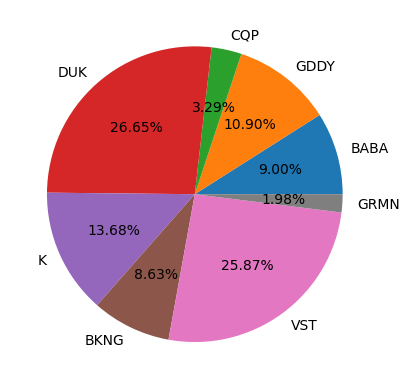

In [10]:
import matplotlib.pyplot as plt

plt.pie(portfolio_allocation_high_sharpe['Stock Weights'], 
        labels=portfolio_allocation_high_sharpe['Stocks'],
        autopct='%1.2f%%')


In [11]:
portfolio_allocation_high_sharpe['Stock Weights'] * 30_000 * 1.07

array([ 3384.48516296,  4097.96964115,  1236.89737743, 10020.87947339,
        5145.73231954,  3247.02412669,  9728.07006943,   744.46335975])